In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from collections import Counter

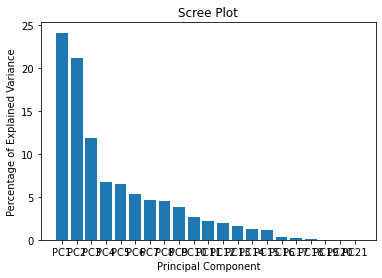

PC2     0.201563
PC6     0.192061
PC9     0.093385
PC8     0.053768
PC5     0.022722
PC3     0.011284
PC4     0.003929
PC7    -0.059350
PC10   -0.107302
PC1    -0.737142
Name: wl_home, dtype: float64


In [2]:
gameDataframe = pd.read_csv("game.csv")
# print(gameDataframe)
gameDataframe['game_date'] = pd.to_datetime(gameDataframe['game_date'])

# Filter the data to only include rows from 2000 onwards
filtered_df = gameDataframe[gameDataframe['game_date'].dt.year >= 2000].copy()
# print(filtered_df)

filtered_df['wl_home'] = filtered_df['wl_home'].map({'W': 1, 'L': 0})
filtered_df = filtered_df.reset_index(drop=True)

#####

non_numeric_columns = filtered_df.select_dtypes(exclude =[np.number]).columns
filtered_df = filtered_df.select_dtypes(include = [np.number])

####

correlations = filtered_df.corr()['wl_home'].abs().sort_values(ascending=False)
remainingFeatures = correlations[correlations > .15].index #indexes of all features with a correlations above 15 percent towards the win or loss of a home team
# print(remainingFeatures)

scaler = StandardScaler()
reducedData = filtered_df[remainingFeatures].drop(columns=['wl_home'])
scaledData = scaler.fit_transform(reducedData)
pca = PCA()
# pca.fit(scaledData)
pcaData = pca.fit_transform(scaledData)

percentVar = np.round(pca.explained_variance_ratio_*100,decimals= 1)
labels = ['PC' + str(x) for x in range(1,len(percentVar) + 1)]
plt.bar(x = range(1,len(percentVar)+1),height=percentVar,tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()


pca_df = pd.DataFrame(pcaData[:,:10], columns=[f'PC{i+1}' for i in range(10)]) #top 10 principal components account for ~90% variance 
pca_df['wl_home'] = filtered_df['wl_home']
correlations_with_win = pca_df.corr()['wl_home'].drop('wl_home').sort_values(ascending=False)
# print(filtered_df['wl_home'])
# print(pca_df)
print(correlations_with_win)

Observing the Scree plot give us insight towards the Principal Components that contribute the highest percentage of variance in general. It's important to note that this is general variance, not variance directly pertaining towards the win or loss of the home team. 

Conversely, the printed correlations are tied directly to the win or loss of the home team for each Principal Component. As we can see, the most explanatory principal component is PC1, which is negatively correlated with the win or loss of the home team. Meaning, if there is a high value for PC1 in a given game, that game lends itself to being more likely to having been a loss for the home team. While other factors such as PC2 and PC6 are among the higher correlated PC's with W/L, their correlation contstant is not nearly as dominant as PC1's.

It's important to note, this is data collected after the fact. Since our model is looking to predict the outcome of games, these statistics can't necessarily help us as we have no indication as to how these features will play out in a given game. However, there is some merit into observing the cumulative of these values leading up to each game. If a team is consistently putting up high contributions towards the PC1 feature, for example, we could therefore assume it is less likely they will win their following game.

Index(['wl_home', 'plus_minus_home', 'fg3_pct_home', 'fg_pct_home',
       'dreb_home', 'reb_home', 'stl_home', 'pts_home', 'fgm_home', 'ftm_home',
       'tov_away', 'fta_home', 'pf_away', 'fg3a_away'],
      dtype='object')
Index(['PC1', 'PC4', 'PC10', 'PC2', 'PC7', 'PC9', 'PC5'], dtype='object')


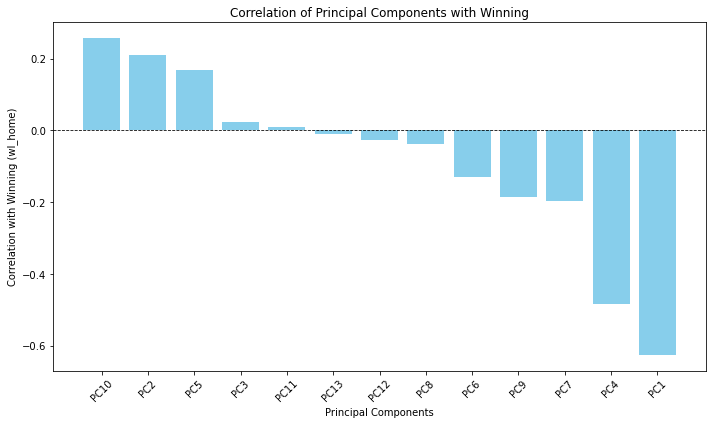

In [3]:
filtered_df = gameDataframe[gameDataframe['game_date'].dt.year == 2023].copy()
# print(filtered_df)
filtered_df['wl_home'] = filtered_df['wl_home'].map({'W': 1, 'L': 0})
filtered_df = filtered_df.reset_index(drop=True)
filtered_df = filtered_df.sort_values(by='game_date')

filtered_df = filtered_df[filtered_df['team_name_home'] != 'Team LeBron']

mean_last_20_to_11_games = ( ####2nd most recent game to nth most recent game
    filtered_df.groupby('team_name_home')
    .apply(lambda x: x.iloc[-13:-2].select_dtypes(include='number').mean())  
    .drop(columns=['season_id','team_id_home','game_id'])
    .reset_index(drop = True)
    # .drop(columns=['wl_home'])  # Optional: Drop 'wl_home' if it's not needed in the result
)


mean_last_10_games = ( ##### LAST GAME
    filtered_df.groupby('team_name_home')
    .apply(lambda x: x.iloc[-2:-1].select_dtypes(include='number').mean()) 
    .drop(columns=['season_id','team_id_home','game_id'])
    .reset_index(drop = True)
    # .drop(columns=['wl_home'])  # Optional: Drop 'wl_home' if it's not needed in the result
)


ten_to_twenty_games_win = mean_last_20_to_11_games["wl_home"]
last_ten_games_win = mean_last_10_games["wl_home"]
correlations = mean_last_20_to_11_games.corr()['wl_home'].sort_values(ascending=False)
remainingFeatures = correlations[correlations > .15].index #indexes of all features with a correlations above 15 percent towards the win or loss of a home team
remainingFeaturesTest = remainingFeatures.drop('wl_home')
print(remainingFeatures)


scaler = StandardScaler()
mean_last_20_to_11_games = mean_last_20_to_11_games[remainingFeatures]
reducedData = mean_last_20_to_11_games.drop(columns=['wl_home'])
rows_with_na = reducedData.isna().any(axis=1)
reducedData = reducedData.dropna()
scaledData = scaler.fit_transform(reducedData)
pca = PCA()
pcaData = pca.fit_transform(scaledData)

# percentVar = np.round(pca.explained_variance_ratio_[:12]*100,decimals= 1)
# labels = ['PC' + str(x) for x in range(1,13)]
# plt.bar(x = range(1,13),height=percentVar,tick_label = labels)
# plt.ylabel('Percentage of Explained Variance')
# plt.xlabel('Principal Component')
# plt.title('Scree Plot')

pca_df = pd.DataFrame(pcaData, columns=[f'PC{i+1}' for i in range(pcaData.shape[1])]) #top 10 principal components account for ~90% variance 

# pca_df['wl_home'] = last_ten_games_win
pca_df['wl_home'] = ten_to_twenty_games_win

# print(pca_df)
pcacorrelations_with_win = pca_df.corr()['wl_home'].drop('wl_home').abs().sort_values(ascending=False)
remainingPCAFeatures = pcacorrelations_with_win[pcacorrelations_with_win > .15].index
pcacorrelations_with_win = pca_df.corr()['wl_home'].drop('wl_home').sort_values(ascending=False)
print(remainingPCAFeatures)

#################################################################

plt.figure(figsize=(10, 6))
plt.bar(pcacorrelations_with_win.index, pcacorrelations_with_win.values, color='skyblue')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Correlation of Principal Components with Winning')
plt.xlabel('Principal Components')
plt.ylabel('Correlation with Winning (wl_home)')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.show()

pca_df['win_category'] = np.where(pca_df['wl_home'] >= 0.5, 'Above 50%', 'Below 50%')

# # fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC4', color='wl_home',
# #                     labels={'wl_home': 'Win Percentage'},
# #                     title='3D Scatter Plot of PCA Components vs Win Percentage',
# #                     color_continuous_scale=px.colors.sequential.Viridis)

fig = px.scatter(pca_df,x = 'PC1', y= 'PC4', color = 'win_category')
fig.show()

# 3D Scatter Plot using Plotly with 2 color categories
fig = px.scatter_3d(pca_df, x='PC1', y='PC4', z='PC7', color='win_category',
                    color_discrete_map={'Above 50%': 'blue', 'Below 50%': 'red'},
                    title='3D Scatter Plot of PCA Components vs Win Percentage')

# Update layout for better readability
fig.update_traces(marker=dict(size=5))  # Adjust marker size if needed
fig.update_layout(scene=dict(
    xaxis_title='Principal Component 1',
    yaxis_title='Principal Component 2',
    zaxis_title='Principal Component 4',
))

fig.show()


This portion of the data reduction is much more relevant towards the scope of our project. By focusing on the mean of the features of each team from their last 10 games, we can get a good understanding of how the team is performing in general at the time of their upcoming games, as well as the most important features that are contributing towards their wins or losses. 

By identifying the principal components that are most directly correlated (positive or negative), we a good idea of predicting the outcomes of future games by using these principal components and seeing how they reflect a team leading up to their future games.

Looking at the bar graph from the second graphic, we can see that there are several PC's that are heavily correlated with winning. PC1 and PC2 are negatively correlated with winning, and PC4 is positively correlated with winning. While not perfect, we can get a general understanding of this by plotting it in a 3-Dimensional space as graphic #3 has done. As you can see, when we move towards a higher value of PC1 and PC2, the percentage of winning goes down, and conversely when we move towards a lower value of PC1 and PC2 winning goes up. The opposite can be true of PC4. While this portion of our project is not used to draw definitive conclusions or predictions, this can establish a solid foundation for our machine learning models to use when predicting the outcome of games.

In [4]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_train)[:, 1])

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')

    c_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title('Confusion Matrix')
    plt.show()

In [442]:
def evaluate_model_rf(gameWindow, earliestGame):
    # randomforest_df = gameDataframe[gameDataframe['game_date'].dt.year >= 2022-10-18].copy()
    randomforest_df = gameDataframe[gameDataframe['game_date'] >= "2022-10-18"].copy()
    # randomforest_df = gameDataframe[gameDataframe['game_date'] <= "2022-04-18"].copy()
    randomforest_df['wl_home'] = randomforest_df['wl_home'].map({'W': 1, 'L': 0})
    randomforest_df = randomforest_df.reset_index(drop=True)
    randomforest_df = randomforest_df.sort_values(by='game_date')
    randomforest_df = randomforest_df[randomforest_df["season_type"] == "Regular Season"]

    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team LeBron']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona FC Barcelona Lassa']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona FC Barcelona Regal']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona Regal FC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona Winterthur FC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'West NBA All Stars West']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Washington Bullets']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Berlin Alba Berlin']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Bilbao Basket']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Charlotte Bobcats']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'China Team China']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'East NBA All Stars East']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Flamengo Flamengo']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Istanbul Efes Pilsen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Istanbul Fenerbahce Ulker']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Khimki BC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Lottomatica Lottomatica Roma']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Lyon-Villeurbanne Adecco ASVEL']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'MMT Estudiantes MMT Estudiantes']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Madrid Real Madrid']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano Armani Jeans Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano EA7 Emporio Armani Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano Olimpia Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'New Orleans/Oklahoma City Hornets']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Vancouver Grizzlies']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Unicaja Malaga Unicaja Malaga']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Real Madrid Real Madrid']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Roma Virtus Lottomatica']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Seattle SuperSonics']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Durant']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Giannis']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Team Stephen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Stephen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']

    
    
    ########################
    ## Feature Engineering
    rolling_window = 5
    momentum_window = 5
    momentum_diff = 10 
    randomforest_df['home_advantage'] = randomforest_df['pts_home'] - randomforest_df['pts_away']
    randomforest_df['turnover_fg_interaction'] = randomforest_df['tov_home'] * randomforest_df['fg_pct_home']
    randomforest_df['rolling_std_points'] = (
        randomforest_df.groupby('team_name_home')['pts_home']
        .transform(lambda x: x.rolling(rolling_window, min_periods=1).std())
    )
    randomforest_df['momentum'] = (
        randomforest_df.groupby('team_name_home')['pts_home']
        .transform(lambda x: x.rolling(momentum_window, min_periods=1).mean())
        - randomforest_df.groupby('team_name_home')['pts_home']
        .transform(lambda x: x.shift(momentum_diff).rolling(momentum_window, min_periods=1).mean())
    )

    randomforest_df['recent_wins_opp'] = (
    randomforest_df.groupby('team_name_away')['wl_home']
    .transform(lambda x: x.rolling(window=rolling_window, min_periods=1).sum())
    )
    
    randomforest_df['opp_win_pct'] = (
    randomforest_df.groupby('team_name_away')['wl_home']
    .transform(lambda x: x.expanding().mean())
    )

    randomforest_df['opp_momentum'] = (
    randomforest_df.groupby('team_name_away')['pts_away']
    .transform(lambda x: x.rolling(momentum_window, min_periods=1).mean())
    - randomforest_df.groupby('team_name_away')['pts_away']
    .transform(lambda x: x.shift(momentum_diff).rolling(momentum_window, min_periods=1).mean())
    )

    #######################
    latestGame = (earliestGame - gameWindow) * -1 ##e.g. latestGame = -40
    earliestGame *= - 1 ##e.g. earliestGame = -50
    mean_games_train = ( ####2nd most recent game to nth most recent game
        randomforest_df.groupby('team_name_home')
        .apply(lambda x: x.iloc[earliestGame:latestGame].select_dtypes(include='number').mean())  
        .drop(columns=['season_id','team_id_home','game_id'])
        .reset_index(drop = True)
    )
    # print(randomforest_df.groupby('team_name_home').mean())
    # print(mean_games_train)
    testGame = latestGame + 1 ##e.g. testGame = -39

    team_test_game = ( ##### LAST GAME
        randomforest_df.groupby('team_name_home')
        .apply(lambda x: x.iloc[latestGame:testGame].select_dtypes(include='number').mean()) 
        .drop(columns=['season_id','team_id_home','game_id'])
        .reset_index(drop = True)
    )


    rfCorrelations = mean_games_train.corr()['wl_home'].abs().sort_values(ascending=False)
    # print(rfCorrelations)
    rfRemainingFeatures = rfCorrelations[rfCorrelations > .55].index #indexes of all features with a correlations above 15 percent towards the win or loss of a home team
    # remainingFeaturesTest = remainingFeatures.drop('wl_home')

    return mean_games_train,rfRemainingFeatures,team_test_game

In [325]:
def test():
    return 0
    randomforest_df = gameDataframe[gameDataframe['game_date'] >= "2022-10-18"].copy()
    randomforest_df['wl_home'] = randomforest_df['wl_home'].map({'W': 1, 'L': 0})
    randomforest_df = randomforest_df.reset_index(drop=True)
    randomforest_df = randomforest_df.sort_values(by='game_date')
    randomforest_df = randomforest_df[randomforest_df["season_type"] == "Regular Season"]

    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team LeBron']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona FC Barcelona Lassa']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona FC Barcelona Regal']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona Regal FC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona Winterthur FC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'West NBA All Stars West']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Washington Bullets']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Berlin Alba Berlin']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Bilbao Basket']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Charlotte Bobcats']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'China Team China']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'East NBA All Stars East']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Flamengo Flamengo']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Istanbul Efes Pilsen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Istanbul Fenerbahce Ulker']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Khimki BC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Lottomatica Lottomatica Roma']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Lyon-Villeurbanne Adecco ASVEL']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'MMT Estudiantes MMT Estudiantes']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Madrid Real Madrid']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano Armani Jeans Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano EA7 Emporio Armani Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano Olimpia Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'New Orleans/Oklahoma City Hornets']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Vancouver Grizzlies']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Unicaja Malaga Unicaja Malaga']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Real Madrid Real Madrid']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Roma Virtus Lottomatica']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Seattle SuperSonics']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Durant']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Giannis']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Team Stephen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Stephen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']

    mean_games_train = ( ####2nd most recent game to nth most recent game
        randomforest_df.groupby('team_name_home')
        .apply(lambda x: x.iloc[-25:-24])  
        # .drop(columns=['season_id','team_id_home','game_id'])
        # .reset_index(drop = True)
    )
    mean_games_train

In [427]:
def evaluate_model_rf_pca(gameWindow, earliestGame):
    # randomforest_df = gameDataframe[gameDataframe['game_date'].dt.year >= 2022-10-18].copy()
    randomforest_df = gameDataframe[gameDataframe['game_date'] >= "2022-10-18"].copy()
    # randomforest_df = gameDataframe[gameDataframe['game_date'] <= "2022-04-18"].copy()
    randomforest_df['wl_home'] = randomforest_df['wl_home'].map({'W': 1, 'L': 0})
    randomforest_df = randomforest_df.reset_index(drop=True)
    randomforest_df = randomforest_df.sort_values(by='game_date')
    randomforest_df = randomforest_df[randomforest_df["season_type"] == "Regular Season"]

    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team LeBron']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona FC Barcelona Lassa']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona FC Barcelona Regal']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona Regal FC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Barcelona Winterthur FC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'West NBA All Stars West']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Washington Bullets']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Berlin Alba Berlin']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Bilbao Basket']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Charlotte Bobcats']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'China Team China']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'East NBA All Stars East']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Flamengo Flamengo']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Istanbul Efes Pilsen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Istanbul Fenerbahce Ulker']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Khimki BC']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Lottomatica Lottomatica Roma']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Lyon-Villeurbanne Adecco ASVEL']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'MMT Estudiantes MMT Estudiantes']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Madrid Real Madrid']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano Armani Jeans Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano EA7 Emporio Armani Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Milano Olimpia Milano']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'New Orleans/Oklahoma City Hornets']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Vancouver Grizzlies']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Unicaja Malaga Unicaja Malaga']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Real Madrid Real Madrid']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Roma Virtus Lottomatica']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Seattle SuperSonics']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Durant']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Giannis']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Team Stephen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Stephen']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']
    randomforest_df = randomforest_df[randomforest_df['team_name_home'] != 'Team Tel Aviv Maccabi Elite']

    
    
    ########################
    ## Feature Engineering
    rolling_window = 5
    momentum_window = 5
    momentum_diff = 10 
    randomforest_df['home_advantage'] = randomforest_df['pts_home'] - randomforest_df['pts_away']
    randomforest_df['turnover_fg_interaction'] = randomforest_df['tov_home'] * randomforest_df['fg_pct_home']
    randomforest_df['rolling_std_points'] = (
        randomforest_df.groupby('team_name_home')['pts_home']
        .transform(lambda x: x.rolling(rolling_window, min_periods=1).std())
    )
    randomforest_df['momentum'] = (
        randomforest_df.groupby('team_name_home')['pts_home']
        .transform(lambda x: x.rolling(momentum_window, min_periods=1).mean())
        - randomforest_df.groupby('team_name_home')['pts_home']
        .transform(lambda x: x.shift(momentum_diff).rolling(momentum_window, min_periods=1).mean())
    )

    randomforest_df['recent_wins_opp'] = (
    randomforest_df.groupby('team_name_away')['wl_home']
    .transform(lambda x: x.rolling(window=rolling_window, min_periods=1).sum())
    )
    
    randomforest_df['opp_win_pct'] = (
    randomforest_df.groupby('team_name_away')['wl_home']
    .transform(lambda x: x.expanding().mean())
    )

    randomforest_df['opp_momentum'] = (
    randomforest_df.groupby('team_name_away')['pts_away']
    .transform(lambda x: x.rolling(momentum_window, min_periods=1).mean())
    - randomforest_df.groupby('team_name_away')['pts_away']
    .transform(lambda x: x.shift(momentum_diff).rolling(momentum_window, min_periods=1).mean())
    )

    #######################
    latestGame = (earliestGame - gameWindow) * -1 ##e.g. latestGame = -40
    earliestGame *= - 1 ##e.g. earliestGame = -50
    mean_games_train = ( ####2nd most recent game to nth most recent game
        randomforest_df.groupby('team_name_home')
        .apply(lambda x: x.iloc[earliestGame:latestGame].select_dtypes(include='number').mean())  
        .drop(columns=['season_id','team_id_home','game_id'])
        .reset_index(drop = True)
    )
    trainGameWins = mean_games_train['wl_home']
    # print(randomforest_df.groupby('team_name_home').mean())
    # print(mean_games_train)
    testGame = latestGame + 1 ##e.g. testGame = -39
    
    team_test_game = ( ##### LAST GAME
        randomforest_df.groupby('team_name_home')
        .apply(lambda x: x.iloc[latestGame:testGame].select_dtypes(include='number').mean()) 
        .drop(columns=['season_id','team_id_home','game_id'])
        .reset_index(drop = True)
    )
    rfCorrelations = mean_games_train.corr()['wl_home'].abs().sort_values(ascending=False)
    rfRemainingFeatures = rfCorrelations[rfCorrelations > .60].index #indexes of all features with a correlations above 15 percent towards the win or loss of a home team

    scaler = StandardScaler()
    mean_games_train = mean_games_train[rfRemainingFeatures]

    # reducedData = mean_last_20_to_11_games.drop(columns=['wl_home'])
    # rows_with_na = reducedData.isna().any(axis=1)
    # reducedData = reducedData.dropna()
# 
    scaledData = scaler.fit_transform(mean_games_train)
    pca = PCA()
    pcaTrainData = pca.fit_transform(scaledData)
    # print(pcaTrainData)
    pcaTrainDf = pd.DataFrame(pcaTrainData, columns=[f'PC{i+1}' for i in range(pcaTrainData.shape[1])]) #top 10 principal components account for ~90% variance 
    pcaTrainDf['wl_home'] = trainGameWins
    # print(pcaTrainDf)
    pcacorrelations_with_win = pcaTrainDf.corr()['wl_home'].drop('wl_home').abs().sort_values(ascending=False)
    # print(pcacorrelations_with_win)
    remainingPCAFeatures = pcacorrelations_with_win[pcacorrelations_with_win > .20].index
    # return mean_games_train,rfRemainingFeatures,team_test_game
    return pcaTrainDf,remainingPCAFeatures,team_test_game

Cumulative Accuracy: 0.611


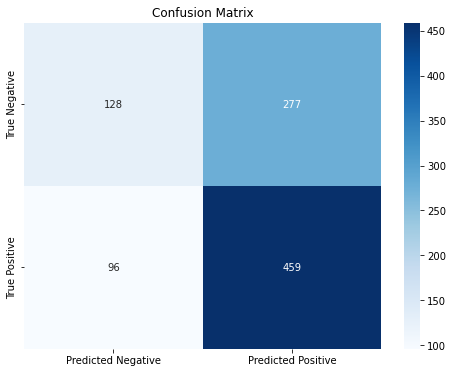

In [464]:
gameWindow = 8
earliestGame = 41
accuracyList = []
n = 0
cumulative_cm = np.zeros((2, 2), dtype=int)
x = 0

while(earliestGame - gameWindow > 1):
    x += 1
    # print(x) 
    mean_games_train,rfRemainingFeatures,team_test_game = evaluate_model_rf(gameWindow,earliestGame)
    # print(rfRemainingFeatures)
    xTrain = mean_games_train[rfRemainingFeatures]
    yTrain = mean_games_train["wl_home"]
    xTrain = xTrain.dropna()
    yTrain = yTrain[xTrain.index]
    yTrain = np.where(yTrain >= .50, 1, 0)
    yTest = team_test_game["wl_home"]
    yTest = yTest[xTrain.index]
    # print(yTest)

    rf = RandomForestClassifier(n_estimators=15,max_depth= None,max_features= int(xTrain.shape[1]),min_samples_leaf=1,min_samples_split=2)
    rf.fit(xTrain, yTrain)
    yPred = rf.predict(xTrain)
    # print(yPred)

    # yPred_proba = rf.predict_proba(xTrain)
    # threshold = 0. # Adjust threshold
    # if (yPred_proba.shape[1] != 2):
    #     yPred = rf.predict(xTrain)
    # else:
    #     yPred = (yPred_proba[:,1] >= threshold).astype(int)

    accuracyList.append(accuracy_score(yTest,yPred))
    # print(accuracy_score(yPred,yTest))
    cm = confusion_matrix(yTest, yPred, labels=[0, 1])  # Ensure labels are consistent
    cumulative_cm += cm

    earliestGame = earliestGame - 1
    n += 1
finalAccuracy = round(sum(accuracyList)/n,3)
print("Cumulative Accuracy:",finalAccuracy)
plt.figure(figsize=(8,6))
sns.heatmap(cumulative_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.show()

Cumulative Accuracy: 0.6135416666666667


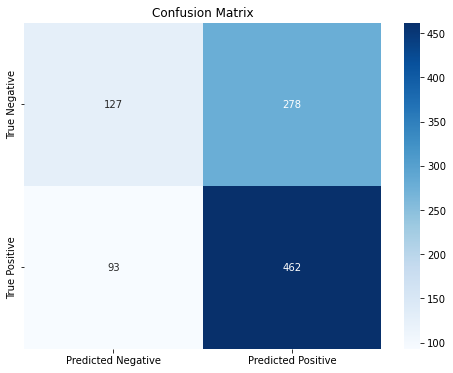

In [445]:
gameWindow = 8
earliestGame = 41
accuracyList = []
n = 0
cumulative_cm = np.zeros((2, 2), dtype=int)
x = 0
while(earliestGame - gameWindow > 1):
    x += 1
    # print(x)
    mean_games_train,rfRemainingFeatures,team_test_game = evaluate_model_rf_pca(gameWindow,earliestGame)
    xTrain = mean_games_train[rfRemainingFeatures]
    yTrain = mean_games_train["wl_home"]
    xTrain = xTrain.dropna()
    yTrain = yTrain[xTrain.index]
    yTrain = np.where(yTrain >= .50, 1, 0)
    yTest = team_test_game["wl_home"]
    yTest = yTest[xTrain.index]

    rf = RandomForestClassifier(n_estimators=5,max_depth= None,max_features= int(xTrain.shape[1]),min_samples_leaf=1,min_samples_split=2)
    rf.fit(xTrain, yTrain)
    yPred = rf.predict(xTrain)


    # yPred_proba = rf.predict_proba(xTrain)
    # threshold = 0.6 # Adjust threshold
    # if (yPred_proba.shape[1] != 2):
    #     yPred = rf.predict(xTrain)
    # else:
    #     yPred = (yPred_proba[:,1] >= threshold).astype(int)

    accuracyList.append(accuracy_score(yTest,yPred))
    cm = confusion_matrix(yTest, yPred, labels=[0, 1])  # Ensure labels are consistent
    cumulative_cm += cm

    earliestGame = earliestGame - 1
    n += 1
finalAccuracy = sum(accuracyList)/n
print("Cumulative Accuracy:",finalAccuracy)
plt.figure(figsize=(8,6))
sns.heatmap(cumulative_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.show()

/Users/jeffrothwell/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/jeffrothwell/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Cumulative Accuracy: 0.6135416666666665


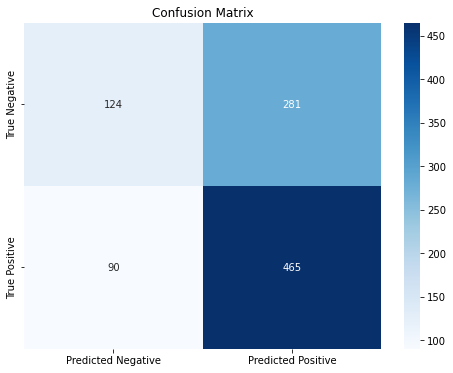

In [ ]:
gameWindow = 8
earliestGame = 41
accuracyList = []
n = 0
cumulative_cm = np.zeros((2, 2), dtype=int)
while(earliestGame - gameWindow > 1):
    mean_games_train,rfRemainingFeatures,team_test_game = evaluate_model_rf(gameWindow,earliestGame)
    xTrain = mean_games_train[rfRemainingFeatures]
    scaler = StandardScaler()
    xTrain = scaler.fit_transform(xTrain)
    yTrain = mean_games_train["wl_home"]
    yTrain = np.where(yTrain >= .50, 1, 0)
    yTest = team_test_game["wl_home"]

    # model = LogisticRegression(class_weight='balanced',C=.1)
    model = LogisticRegression()
    model.fit(xTrain, yTrain)
    yPred = model.predict(xTrain)
    
    # yPred_proba = model.predict_proba(xTrain)
    # # print(yPred_proba)
    # threshold = 0.55 # Adjust threshold
    # if (yPred_proba.shape[1] != 2):
    #     yPred = model.predict(xTrain)
    # else:
    #     yPred = (yPred_proba[:,1] >= threshold).astype(int)


    accuracyList.append(accuracy_score(yTest,yPred))
    cm = confusion_matrix(yTest, yPred, labels=[0, 1])  # Ensure labels are consistent
    cumulative_cm += cm

    earliestGame = earliestGame - 1
    n += 1
finalAccuracy = sum(accuracyList)/n
print("Cumulative Accuracy:",finalAccuracy)
plt.figure(figsize=(8,6))
sns.heatmap(cumulative_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.show()

Basic Model
Accuracy: 0.5667
Precision: 0.4706
Recall: 0.6667
F1 score: 0.5517
ROC-AUC: 0.6019


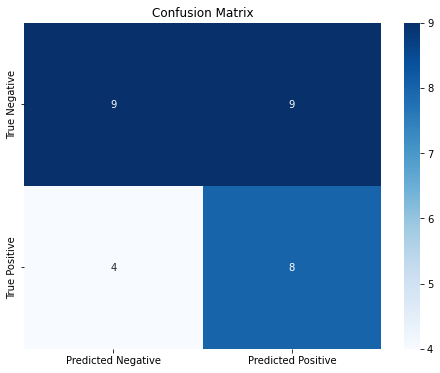

Balanced Model
Accuracy: 0.5333
Precision: 0.4375
Recall: 0.5833
F1 score: 0.5000
ROC-AUC: 0.5926


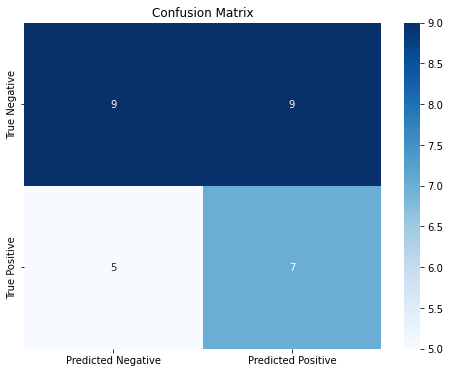

In [ ]:
y_train = mean_last_20_to_11_games["wl_home"].dropna()
y_train = np.where(y_train >= .5, 1, 0)
regressionData = pca_df[remainingPCAFeatures]
X_train = regressionData
y_test = mean_last_10_games["wl_home"] #name is misleading. This is a 1 if the team won their SINGULAR most recent game, and 0 otherwise
# X_train = mean_last_20_to_11_games[remainingFeatures]



###############################
# filtered_df = filtered_df[filtered_df['team_name_home'] != 'Team LeBron']
# y_test = (
#     filtered_df.groupby('team_name_home')
#     .apply(lambda x: x.iloc[-1]['wl_home'])  # Only the latest game outcome per team
#     .reset_index(drop=True)
# )


X_test = np.empty((len(y_test), X_train.shape[1]))
#Fit without params

model = LogisticRegression()
print('Basic Model')
evaluate_model(model, X_train, X_test, y_train, y_test)

#Fit with params
balanced_model = LogisticRegression(
    class_weight = 'balanced',
    C = 0.1,
)
print('Balanced Model')
evaluate_model(balanced_model, X_train, X_test, y_train, y_test)

Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.83      0.56      0.67        18
         1.0       0.56      0.83      0.67        12

    accuracy                           0.67        30
   macro avg       0.69      0.69      0.67        30
weighted avg       0.72      0.67      0.67        30



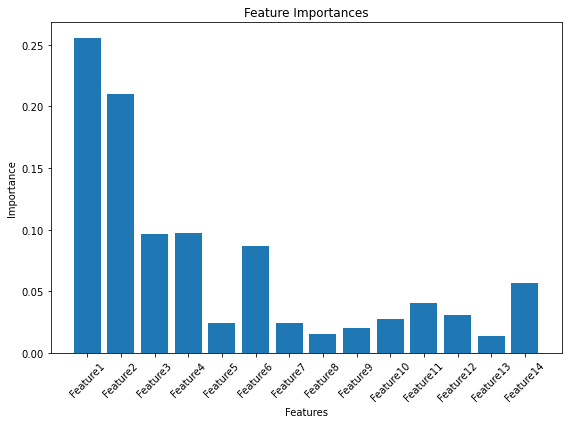

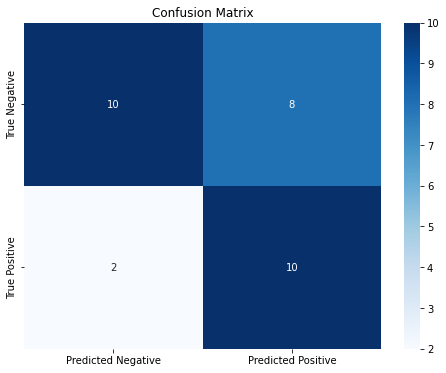

In [21]:
sqrt = np.sqrt(remainingFeatures.size)
xTrain1 = mean_last_20_to_11_games[remainingFeatures] # name is misleading. This is the averages of each team from their 11th to 2nd most recent games, reduced to just the most important features so that we're not overfeeding the model
yTrain1 = mean_last_20_to_11_games["wl_home"]
yTrain1 = np.where(yTrain1 >= .5, 1, 0)
yTest1 = mean_last_10_games["wl_home"] #name is misleading. This is a 1 if the team won their SINGULAR most recent game, and 0 otherwise



param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}



rf = RandomForestClassifier(n_estimators=50,max_depth= None,max_features= int(np.sqrt(np.ceil(xTrain1.shape[1]))),min_samples_leaf=1,min_samples_split=2)
rf.fit(xTrain1, yTrain1)
# Make predictions and evaluate the model
yPred1 = rf.predict(xTrain1)
print("Accuracy:", accuracy_score(yTest1, yPred1))
print(classification_report(yTest1, yPred1))

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
# grid_search.fit(xTrain1, yTrain1)
# print("Best Parameters:", grid_search.best_params_)

# Plot the feature importances
importances = rf.feature_importances_
# print(importances)
plt.figure(figsize=(8, 6))
plt.bar(
    range(len(importances)),
    importances,
    tick_label=[f'Feature{i+1}' for i in range(len(importances))]
)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

c_matrix = confusion_matrix(yTest1, yPred1)
plt.figure(figsize=(8,6))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.show()

In [ ]:
filtered_df = gameDataframe[gameDataframe['game_date'].dt.year >= 2000].copy()
filtered_df['wl_home'] = filtered_df['wl_home'].map({'W': 1, 'L': 0})
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.dropna(inplace=True)

non_numeric_columns = filtered_df.select_dtypes(exclude=[np.number]).columns
filtered_df = filtered_df.select_dtypes(include=[np.number])

correlations = filtered_df.corr()['wl_home'].abs().sort_values(ascending=False)

remainingFeatures = correlations[correlations > .15].index 

scaler = StandardScaler()
reducedData = filtered_df[remainingFeatures]
x_set = reducedData.drop(columns='wl_home')
y_set = reducedData['wl_home']
x_set_scaled = scaler.fit_transform(x_set)

pca_3 = PCA(n_components=3)
new_dataset = pca_3.fit_transform(x_set_scaled) # scaledData is just X

#########

clustering = DBSCAN()
clustering.fit(new_dataset)
print(f'Number of clusters: {len(np.unique(clustering.labels_))}')
print(f'Number of "outliers": {len(np.where(clustering.labels_ == -1)[0])}')
print(f'N: {len(x_set)}')

# Do we want to delete these "outliers" from the dataset?

In [ ]:
cleaned_game_stats_home = filtered_df.iloc[:, 7:28].copy() # only the home numerical data
# print(cleaned_game_stats_home)
cleaned_game_stats_home.dropna(inplace=True)
x_set = cleaned_game_stats_home.iloc[:, 1:]
# print(x_set)
x_set_std = (x_set-x_set.mean())/x_set.std()
y_set = cleaned_game_stats_home.iloc[:, 0]
# print(y_set)

In [ ]:
lasso_fit = Lasso(alpha=0.02, max_iter=10000)
lasso_fit.fit(x_set_std, y_set)
feats = np.where(lasso_fit.coef_ != 0)[0]
feats

In [ ]:
selected_dataset = x_set.iloc[:, feats]

clustering = DBSCAN(eps=0.5, min_samples=3)
clustering.fit(selected_dataset)
print(f'Number of clusters: {len(np.unique(clustering.labels_))}')
print(f'Number of "outliers": {len(np.where(clustering.labels_ == -1)[0])}')
print(f'N: {len(x_set)}')

RANDOM FOREST JALEN's INITIAL MODEL

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Align pcaData and target variable
filtered_df = filtered_df.dropna(subset=['wl_home'])  # Remove rows with NaN in 'wl_home'
scaledData = scaler.fit_transform(filtered_df[remainingFeatures.drop('wl_home')])  # Ensure scaled data matches filtered_df

# Perform PCA again on aligned data
pca = PCA()
pcaData = pca.fit_transform(scaledData)  # Transform aligned scaled data
y_set = filtered_df['wl_home'].reset_index(drop=True)  # Reset index to match pcaData

# Check alignment
assert len(pcaData) == len(y_set), "Mismatch between PCA data and target variable rows"

# Split the PCA data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    pcaData,
    y_set,
    test_size=0.2,
    random_state=42
)

# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot the feature importances
importances = rf.feature_importances_
plt.figure(figsize=(8, 6))
plt.bar(
    range(len(importances)),
    importances,
    tick_label=[f'PC{i+1}' for i in range(len(importances))]
)
plt.title('Feature Importances of PCA Components')
plt.xlabel('Principal Components')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
